## Human pose recognition demo

## import custom model and third party libraries

In [1]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import time
import matplotlib
import awscam
%matplotlib inline
import pylab as plt
from generateLabelCPM import *
from modelCPM import *

## load model

In [2]:
sym = poseSymbol()

In [3]:
modelPath = "/home/aws_cam/faster_184.xml"#"/home/aws_cam/Desktop/default.xml"
modelType = "classification"
mcfg = {"GPU": 1}
aws = awscam.Model(modelPath, mcfg)

## Load parameters

In [4]:
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [5]:
#arg_params

## Load test image

In [6]:
#test_image = 'sample_image/ski.jpg'
ret, test_image = awscam.getLastFrame()
oriImg = test_image # B,G,R order
print oriImg.shape
oriImg = oriImg[0:1520,0:1520,:]


(1520, 2688, 3)


(184, 184, 3)


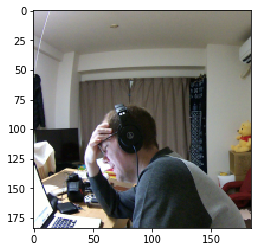

In [7]:
oriImg = image_resize(oriImg, width=184)
print oriImg.shape
f = plt.imshow(oriImg[:,:,[2,1,0]]) # reorder it before displaying

## set related parameters

In [8]:
model={'boxsize':368}
model['stride'] = 8
param={}
param['scale_search'] = [.5, 1, 1.5, 2]
multiplier = [x * model['boxsize']*1.0 / oriImg.shape[0] for x in param['scale_search']]

## Add two functions for testing 

In [11]:
def padRightDownCorner(img, stride, padValue):
    h = img.shape[0]
    w = img.shape[1]

    pad = 4 * [None]
    pad[0] = 0 # up
    pad[1] = 0 # left
    pad[2] = 0 if (h==368) else 184-h # down
    pad[3] = 0 if (w==368) else 184-w # right

    img_padded = img
    pad_up = np.tile(img_padded[0:1,:,:]*0 + padValue, (pad[0], 1, 1))
    img_padded = np.concatenate((pad_up, img_padded), axis=0)
    pad_left = np.tile(img_padded[:,0:1,:]*0 + padValue, (1, pad[1], 1))
    img_padded = np.concatenate((pad_left, img_padded), axis=1)
    pad_down = np.tile(img_padded[-2:-1,:,:]*0 + padValue, (pad[2], 1, 1))
    img_padded = np.concatenate((img_padded, pad_down), axis=0)
    pad_right = np.tile(img_padded[:,-2:-1,:]*0 + padValue, (1, pad[3], 1))
    img_padded = np.concatenate((img_padded, pad_right), axis=1)

    return img_padded, pad

class DataBatch(object):
    def __init__(self, data, label, pad=0):
        self.data = [data]
        self.label = [label]
        self.pad = pad

## Run heatmap  inference algorithm in multi scales 

(184, 184, 3)
[0, 0, 0, 0]
(3, 184, 184)
{'Mconv7_stage4_L2': array([6.5203645e-04, 4.9917720e-04, 4.2148193e-04, ..., 9.6506548e-01,
       9.5474505e-01, 9.5175397e-01], dtype=float32), 'Mconv7_stage4_L1': array([-0.00164717, -0.00164919, -0.00164919, ...,  0.00173593,
        0.00220654,  0.0030608 ], dtype=float32)}
8464
(16, 23, 23)
(23, 23, 16)
(184, 184, 28)


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


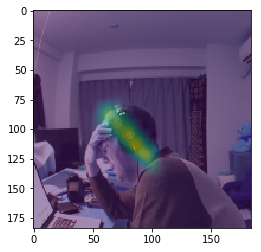

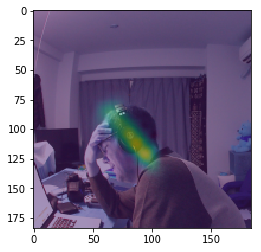

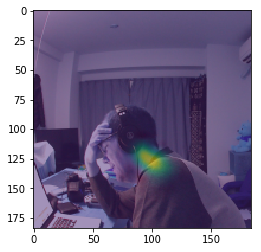

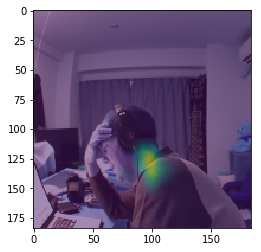

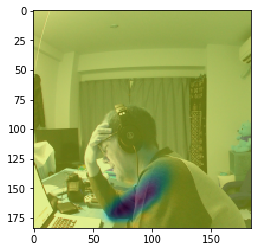

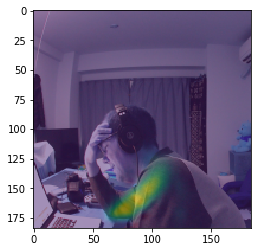

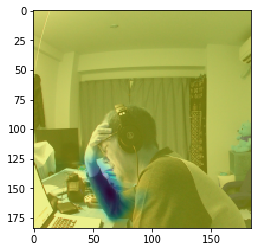

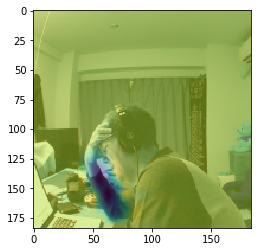

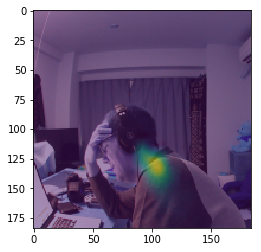

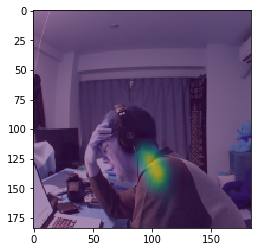

In [13]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 16))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 28))

imageToTest = cv.resize(oriImg, (0,0), fx=1, fy=1, interpolation=cv.INTER_CUBIC)
print imageToTest.shape
imageToTest_padded, pad = padRightDownCorner(imageToTest, 8, 128)

print pad
transposeImage = np.transpose(np.float32(imageToTest_padded[:,:,:]), (2,0,1))/255.0-0.5
#testimage /= (255.0/testimage.max())
print transposeImage.shape
#cmodel = mx.mod.Module(symbol=sym, label_names=[])
#cmodel.bind(data_shapes=[('data', (1,3,
                           #testimage.shape[1],testimage.shape[2]))])
#cmodel.init_params(arg_params=arg_params, aux_params=aux_params)
#onedata = DataBatch(mx.nd.array([testimage[:,:,:]]), 0)

output = aws.doInference(transposeImage)
#cmodel.forward(onedata)
#result=cmodel.get_outputs()
print output
h = output["Mconv7_stage4_L2"]
p = output["Mconv7_stage4_L1"]
print len(h)
heatmap1 = h.reshape([16,23,23]) 
heatmap = np.transpose(heatmap1, (1,2,0))

print heatmap1.shape
print heatmap.shape
#heatmap = np.moveaxis(h, 0, -1)

heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
#print(heatmap)
heatmap_avg = heatmap_avg + heatmap / 1

paf1 = p.reshape([28,23,23])
paf = np.transpose(paf1, (1,2,0))

#paf = np.moveaxis(result[0].asnumpy()[0], 0, -1)
paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
print paf.shape

paf_avg = paf_avg + paf / 1

for i in range(10):
    f = plt.figure(i)
    plt.imshow(oriImg)
    plt.imshow(paf_avg[:,:,i], alpha=.5)
    f.show()


In [19]:
heatmap_avg>1

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

## Show average heatmap of neck

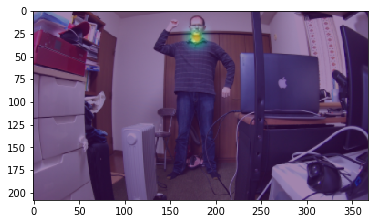

In [20]:
f = plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]])
ax2 = plt.imshow(heatmap_avg[:,:,1], alpha=.5)
f.show()

## Show average heatmap of all human parts

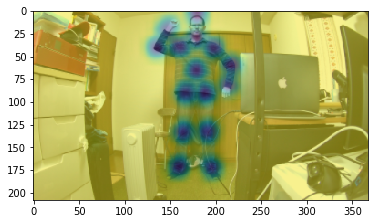

In [21]:
f = plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]])
ax2 = plt.imshow(heatmap_avg[:,:,15], alpha=.5)
f.show()

## Show one part

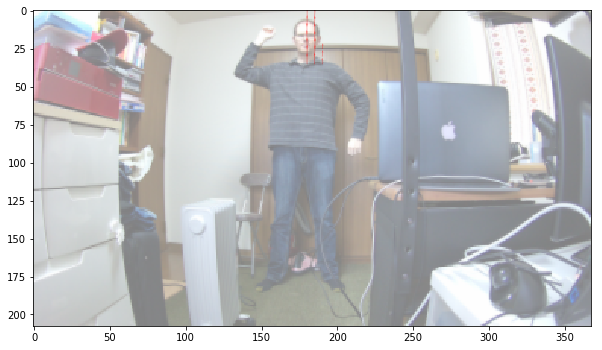

In [22]:
from numpy import ma
U = paf_avg[:,:,0] * -1
V = paf_avg[:,:,1]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

## Get human part 

In [23]:
param={}
param['octave'] = 3
param['use_gpu'] = 1
param['starting_range'] = 0.8
param['ending_range'] = 2
param['scale_search'] = [0.5, 1, 1.5, 2]
param['thre1'] = 0.1
param['thre2'] = 0.05
param['thre3'] = 0.5
param['mid_num'] = 4
param['min_num'] = 10
param['crop_ratio'] = 2.5
param['bbox_ratio'] = 0.25
param['GPUdeviceNumber'] = 3

import scipy
print heatmap_avg.shape

#plt.imshow(heatmap_avg[:,:,2])
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(17-1):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

(208, 368, 16)


In [24]:
## all_peaks
## (x, y, score, id)

In [25]:
len(all_peaks)

16

In [26]:
len(all_peaks[15])

82

In [27]:
for i in all_peaks:
    if(len(i)>10):
        print i

[(26, 0, 1.0015870332717896, 16), (55, 0, 0.9986752271652222, 17), (126, 0, 1.000101923942566, 18), (160, 0, 0.9642803072929382, 19), (205, 0, 1.0055370330810547, 20), (308, 0, 1.003446102142334, 21), (206, 14, 1.008195161819458, 22), (165, 17, 0.9217769503593445, 23), (118, 19, 1.0053026676177979, 24), (224, 34, 1.0121026039123535, 25), (272, 36, 1.0039740800857544, 26), (148, 38, 0.7550974488258362, 27), (110, 43, 1.0112396478652954, 28), (54, 47, 1.0025732517242432, 29), (181, 48, 0.9351319670677185, 30), (276, 54, 1.0038362741470337, 31), (329, 55, 1.0034593343734741, 32), (244, 59, 1.0054919719696045, 33), (99, 61, 1.0046393871307373, 34), (199, 64, 0.9993371963500977, 35), (126, 65, 1.004507064819336, 36), (127, 66, 1.0021499395370483, 37), (143, 72, 1.0052108764648438, 38), (179, 79, 0.7461355328559875, 39), (28, 82, 1.0033186674118042, 40), (240, 82, 1.0131385326385498, 41), (323, 83, 1.0036739110946655, 42), (270, 88, 1.0031206607818604, 43), (271, 89, 1.0031371116638184, 44),

## Link human parts

In [28]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[1, 2], [2, 3], [3, 4], [4, 5], [2, 6], [6, 7], [7, 8], [2, 15], [15, 12],
           [12, 13], [13, 14], [15, 9], [9, 10], [10, 11]]
# the middle joints heatmap correpondence
mapIdx = [[16, 17], [18, 19], [20, 21], [22, 23],
          [24, 25], [26, 27], [28, 29], [30, 31], 
          [38, 39], [40, 41], [42, 43], [32, 33],
          [34, 35], [36, 37]];

In [29]:
connection_all = []
special_k = []
special_non_zero_index = []
mid_num = 11

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-16 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    print(k)
    print(candA)
    print('---------')
    print(candB)
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                # print('vec: ',vec)
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # print('norm: ', norm)
                vec = np.divide(vec, norm)
                # print('normalized vec: ', vec)
                startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num))
                # print('startend: ', startend)
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                # print('vec_x: ', vec_x)
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])
                # print('vec_y: ', vec_y)
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                # print(score_midpts)
                # print('score_midpts: ', score_midpts)
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                
                print('score_with_dist_prior: ', score_with_dist_prior)
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                # print('score_midpts > param["thre2"]: ', len(np.nonzero(score_midpts > param['thre2'])[0]))
                criterion2 = score_with_dist_prior > 0
                
                if criterion1 and criterion2:
                    # print('match')
                    # print(i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2])
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
                # print('--------end-----------')
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        # print('-------------connection_candidate---------------')
        # print(connection_candidate)
        # print('------------------------------------------------')
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                # print('----------connection-----------')
                # print(connection)
                # print('-------------------------------')
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    elif(nA != 0 or nB != 0):
        special_k.append(k)
        special_non_zero_index.append(indexA if nA != 0 else indexB)
        connection_all.append([])

0
[(180, 0, 0.9688783288002014, 0)]
---------
[(179, 30, 0.9277697801589966, 1)]
('score_with_dist_prior: ', 0.9945623556482333)
1
[(179, 30, 0.9277697801589966, 1)]
---------
[(161, 40, 0.9074103236198425, 2)]
('score_with_dist_prior: ', 0.9293299961245083)
2
[(161, 40, 0.9074103236198425, 2)]
---------
[(136, 41, 0.9116212129592896, 3)]
('score_with_dist_prior: ', 1.0997151241273786)
3
[(136, 41, 0.9116212129592896, 3)]
---------
[(147, 21, 0.8663549423217773, 4)]
('score_with_dist_prior: ', 0.9576514114049328)
4
[(179, 30, 0.9277697801589966, 1)]
---------
[(198, 41, 0.8810035586357117, 5)]
('score_with_dist_prior: ', 1.101977422352668)
5
[(198, 41, 0.8810035586357117, 5)]
---------
[(217, 60, 0.8936758041381836, 6)]
('score_with_dist_prior: ', 1.1080054815536193)
6
[(217, 60, 0.8936758041381836, 6)]
---------
[(155, 17, 0.11960941553115845, 7), (214, 82, 0.7962226867675781, 8)]
('score_with_dist_prior: ', -0.026934464723577942)
('score_with_dist_prior: ', 0.8074721240142957)
7
[(17

In [31]:
connection_all

[array([[0.        , 1.        , 0.99456236, 0.        , 0.        ]]),
 array([[1.     , 2.     , 0.92933, 0.     , 0.     ]]),
 array([[2.        , 3.        , 1.09971512, 0.        , 0.        ]]),
 array([[3.        , 4.        , 0.95765141, 0.        , 0.        ]]),
 array([[1.        , 5.        , 1.10197742, 0.        , 0.        ]]),
 array([[5.        , 6.        , 1.10800548, 0.        , 0.        ]]),
 array([[6.        , 8.        , 0.80747212, 0.        , 1.        ]]),
 array([[ 1.        , 15.        ,  1.04390484,  0.        ,  0.        ]]),
 array([[15.        , 12.        ,  1.06342165,  0.        ,  0.        ]]),
 array([[12.        , 13.        ,  0.98152412,  0.        ,  0.        ]]),
 array([[13.       , 14.       ,  0.9570362,  0.       ,  0.       ]]),
 array([[15.        ,  9.        ,  0.96217467,  0.        ,  0.        ]]),
 array([[ 9.        , 10.        ,  0.95996526,  0.        ,  0.        ]]),
 array([[10.        , 11.        ,  0.88883538,  0.   

In [32]:
# connection_all
# pos1, pos2, score, i, j

## Human part connection 

In [33]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))

candidate = np.array([item for sublist in all_peaks for item in sublist])

candidate

array([[1.80000000e+02, 0.00000000e+00, 9.68878329e-01, 0.00000000e+00],
       [1.79000000e+02, 3.00000000e+01, 9.27769780e-01, 1.00000000e+00],
       [1.61000000e+02, 4.00000000e+01, 9.07410324e-01, 2.00000000e+00],
       [1.36000000e+02, 4.10000000e+01, 9.11621213e-01, 3.00000000e+00],
       [1.47000000e+02, 2.10000000e+01, 8.66354942e-01, 4.00000000e+00],
       [1.98000000e+02, 4.10000000e+01, 8.81003559e-01, 5.00000000e+00],
       [2.17000000e+02, 6.00000000e+01, 8.93675804e-01, 6.00000000e+00],
       [1.55000000e+02, 1.70000000e+01, 1.19609416e-01, 7.00000000e+00],
       [2.14000000e+02, 8.20000000e+01, 7.96222687e-01, 8.00000000e+00],
       [1.68000000e+02, 9.00000000e+01, 8.56010020e-01, 9.00000000e+00],
       [1.65000000e+02, 1.33000000e+02, 8.66429865e-01, 1.00000000e+01],
       [1.60000000e+02, 1.71000000e+02, 8.23617876e-01, 1.10000000e+01],
       [1.89000000e+02, 9.00000000e+01, 9.10000086e-01, 1.20000000e+01],
       [1.91000000e+02, 1.33000000e+02, 8.61855626e

In [34]:
for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print "found = 2"
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

In [35]:
subset

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  8.        ,  9.        , 10.        ,
        11.        , 12.        , 13.        , 14.        , 15.        ,
        -1.        , -1.        , -1.        , 27.02217358, 15.        ]])

## Show human part keypoint

In [36]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

cmap = matplotlib.cm.get_cmap('hsv')

#canvas = cv.imread(test_image) # B,G,R order
canvas = np.zeros((368,368,3), np.uint8)

for i in range(15):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

print oriImg.shape
print canvas.shape
to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(11, 11)

(208, 368, 3)
(368, 368, 3)


error: /build/opencv-SviWsf/opencv-2.4.9.1+dfsg/modules/core/src/arithm.cpp:1287: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


## Show human part connection

In [1]:
# visualize 2
stickwidth = 4

for i in range(14):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        print (Y, X, mX, mY)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

NameError: name 'subset' is not defined